# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf

print("GPU Available:", tf.config.list_physical_devices('GPU'))

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

def replace_outliers_with_mean(data, exclude_cols=[]):
    for column in data.columns:
        if column not in exclude_cols:
            q1 = data[column].quantile(0.25)
            q3 = data[column].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            
            data[column] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), 
                                    data[column].mean(), data[column])
    
    return data

GPU Available: []



# Preprocessing

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train = train.drop(train[(train['original'] != 1)].index)

day_under_3 = (train['timestamp(day)'] <= -3)

train.loc[day_under_3, "timestamp(day)"] = float(-3.0)

train.rename(columns={"1":"Gender", "2":"Age"},inplace=True)

train["Gender"].fillna(1,inplace=True)

age = 40
train["Age"].fillna(age,inplace=True)

end_of_record = (train['timestamp(day)'].shift() == 0) & (train['timestamp(hr)'].shift() == 0)

train['end_of_record'] = end_of_record

train = train.fillna(train.mean())

train.info()

train.head()

train['info_target'] = train["Gender"].astype('category').cat.codes.astype(str) + '_'  + train["Age"].astype(str)
train = train.drop(["Gender", "Age"], axis=1)

train.loc[(300 < train['7']) & (train['7'] < 450), '7'] = train.loc[(300 < train['7']) & (train['7'] < 450), '7'] / 10
train.loc[(3000 < train['7']) & (train['7'] < 4500), '7'] = train.loc[(3000 < train['7']) & (train['7'] < 4500), '7'] / 100

train = replace_outliers_with_mean(train, exclude_cols=['info_target','timestamp(day)','timestamp(hrs)','original','end_of_record'])
X = train.drop(['info_target'], axis=1)
Y = train['info_target']

n_neighbors = 2
smote = SMOTE(random_state=42,k_neighbors=n_neighbors)
X_resampled, Y_resampled = smote.fit_resample(X,Y)

balanced_train = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(Y_resampled, name='info_target')], axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175514 entries, 0 to 246000
Data columns (total 38 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Gender          175514 non-null  float64
 1   Age             175514 non-null  float64
 2   3               175514 non-null  float64
 3   4               175514 non-null  float64
 4   5               175514 non-null  float64
 5   6               175514 non-null  float64
 6   7               175514 non-null  float64
 7   8               175514 non-null  float64
 8   9               175514 non-null  float64
 9   10              175514 non-null  float64
 10  11              175514 non-null  float64
 11  12              175514 non-null  float64
 12  13              175514 non-null  float64
 13  14              175514 non-null  float64
 14  15              175514 non-null  float64
 15  16              175514 non-null  float64
 16  17              175514 non-null  float64
 17  18        

In [3]:
balanced_train.info()

balanced_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1517248 entries, 0 to 1517247
Data columns (total 37 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   3               1517248 non-null  float64
 1   4               1517248 non-null  float64
 2   5               1517248 non-null  float64
 3   6               1517248 non-null  float64
 4   7               1517248 non-null  float64
 5   8               1517248 non-null  float64
 6   9               1517248 non-null  float64
 7   10              1517248 non-null  float64
 8   11              1517248 non-null  float64
 9   12              1517248 non-null  float64
 10  13              1517248 non-null  float64
 11  14              1517248 non-null  float64
 12  15              1517248 non-null  float64
 13  16              1517248 non-null  float64
 14  17              1517248 non-null  float64
 15  18              1517248 non-null  float64
 16  19              1517248 non-null  fl

,3,4,5,6,7,8,9,10,11,12,...,30,31,32,33,34,timestamp(day),timestamp(hr),original,end_of_record,info_target
0,65.213491,116.401456,97.710257,20.745451,36.999239,0.041682,0.38787,131.349639,9.663647,11.649286,...,12.425312,127.512195,3.180244,16.068297,12.191436,-3.0,-137.0,1.0,False,0_62.0
1,63.000000,106.000000,106.000000,19.000000,37.000000,0.041682,0.38787,131.349639,9.663647,11.649286,...,12.425312,127.512195,3.180244,16.068297,12.191436,-3.0,-135.0,1.0,False,0_62.0
2,94.000000,144.000000,97.710257,20.745451,36.999239,0.041682,0.38787,131.349639,9.663647,11.649286,...,12.425312,127.512195,3.180244,16.068297,12.191436,-3.0,-133.0,1.0,False,0_62.0
3,88.000000,113.000000,94.000000,15.000000,36.999239,0.041682,0.38787,131.349639,9.663647,11.649286,...,12.425312,127.512195,3.180244,16.068297,12.191436,-3.0,-129.0,1.0,False,0_62.0
4,83.000000,96.000000,98.000000,20.000000,36.300000,0.041682,0.38787,131.349639,9.663647,11.649286,...,12.425312,127.512195,3.180244,16.068297,12.191436,-3.0,-128.0,1.0,False,0_62.0


# EDA


In [4]:
# (1)
count = balanced_train['end_of_record'].value_counts()
print(count)
print('')
print(f"Total patients would be 4155, because 'True' means timestamp(day,hrs) = (0,0)\n")

# (2)
mean_of_day = balanced_train['timestamp(day)'].mean()
median_of_day = balanced_train['timestamp(day)'].median()

print(f"Mean of 'day' = {mean_of_day}")
print(f"Median of 'day' = {median_of_day}\n")


False    1449451
True       67797
Name: end_of_record, dtype: int64

Total patients would be 4155, because 'True' means timestamp(day,hrs) = (0,0)

Mean of 'day' = -1.3002747295494175
Median of 'day' = -1.0



In [5]:
# (3)
df = balanced_train.drop(['timestamp(day)','timestamp(hr)','original','end_of_record','info_target'],axis=1)
mean_values = df.mean(axis=0)
std_values = df.std()
Correlation_matrix = df.corr()

print("Means")
print(f"{mean_values}\n")

Means
3      64.806754
4     114.453765
5      97.532716
6      20.064363
7      36.960889
8       0.041682
9       0.387870
10    131.349639
11      9.663647
12     11.649286
13      0.104105
14      1.126957
15     29.459015
16      9.851521
17      0.154372
18      1.572439
19      0.761487
20     11.592508
21     31.152104
22     33.543383
23     92.973692
24      0.475272
25      4.557596
26      9.712840
27     10.736873
28     81.104594
29     59.355618
30     12.425312
31    127.512195
32      3.180244
33     16.068297
34     12.191436
dtype: float64



In [6]:
print("Standard Deviation")
print(f"{std_values}\n")

Standard Deviation
3     1.104381e+01
4     1.641116e+01
5     1.802042e+01
6     2.915610e+00
7     5.055504e-01
8     8.237228e-13
9     8.136609e-12
10    3.572154e-09
11    1.202027e-10
12    3.394176e-10
13    9.059413e-13
14    3.466693e-11
15    8.658004e-10
16    3.070543e-10
17    4.293565e-12
18    4.652459e-11
19    3.104074e-12
20    1.797835e-10
21    3.450446e-10
22    7.577952e-10
23    3.299619e-10
24    1.235608e-11
25    6.822551e-11
26    2.499886e-10
27    1.184901e-10
28    2.333224e-09
29    4.750766e-10
30    3.521797e-11
31    1.928542e-09
32    4.745576e-11
33    3.276986e-10
34    2.920737e-10
dtype: float64



In [7]:
print("Correlation Matrix")
print(f"{Correlation_matrix}\n")

Correlation Matrix
           3         4         5         6         7         8         9  \
3   1.000000  0.467291  0.063101 -0.036397  0.053888  0.048185 -0.048186   
4   0.467291  1.000000 -0.063666  0.006665 -0.001422 -0.005965  0.005966   
5   0.063101 -0.063666  1.000000  0.166658  0.191347  0.001363 -0.001363   
6  -0.036397  0.006665  0.166658  1.000000  0.045227  0.008397 -0.008396   
7   0.053888 -0.001422  0.191347  0.045227  1.000000  0.032720 -0.032719   
8   0.048185 -0.005965  0.001363  0.008397  0.032720  1.000000 -0.999998   
9  -0.048186  0.005966 -0.001363 -0.008396 -0.032719 -0.999998  1.000000   
10  0.001196 -0.030045  0.000384 -0.045696 -0.011113  0.022418 -0.022418   
11 -0.004201  0.032092  0.002640  0.055935  0.017337 -0.028542  0.028542   
12 -0.004201  0.032092  0.002640  0.055935  0.017337 -0.028542  0.028542   
13  0.048185 -0.005965  0.001363  0.008397  0.032720  1.000000 -0.999998   
14 -0.001752  0.036156 -0.000251  0.060515  0.016919  0.000000  0.000

# (4)

Means: The mean values provide an indication of the central tendency of each feature. For example, feature 3 has a mean of 65.18, feature 4 has a mean of 114.64, and so on. These values represent the average values for each feature in the dataset.

Standard Deviations: The standard deviations reflect the spread or variability of each feature. For instance, feature 3 has a standard deviation of 13.17, feature 4 has a standard deviation of 23.42, and so on. Larger standard deviations indicate greater dispersion of data points around the mean.

Correlation Matrix: The correlation matrix shows the pairwise correlations between features. It provides insights into the relationships or associations between variables. Positive correlations (values close to 1) indicate a direct relationship, while negative correlations (values close to -1) suggest an inverse relationship.

In [8]:
# (5)

X = df
y = balanced_train['info_target']

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

rf = RandomForestRegressor()
rf.fit(X,y)
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

selected_features = feature_importance[:len(X.columns) - 5]
X_selected = X[selected_features.index]

print(X_selected.head())

            5          7           4          3          6         27  \
0   97.710257  36.999239  116.401456  65.213491  20.745451  10.736873   
1  106.000000  37.000000  106.000000  63.000000  19.000000  10.736873   
2   97.710257  36.999239  144.000000  94.000000  20.745451  10.736873   
3   94.000000  36.999239  113.000000  88.000000  15.000000  10.736873   
4   98.000000  36.300000   96.000000  83.000000  20.000000  10.736873   

          23        24        25       26  ...         22        19  \
0  92.973692  0.475272  4.557596  9.71284  ...  33.543383  0.761487   
1  92.973692  0.475272  4.557596  9.71284  ...  33.543383  0.761487   
2  92.973692  0.475272  4.557596  9.71284  ...  33.543383  0.761487   
3  92.973692  0.475272  4.557596  9.71284  ...  33.543383  0.761487   
4  92.973692  0.475272  4.557596  9.71284  ...  33.543383  0.761487   

          20        18        17        16         15        14        13  \
0  11.592508  1.572439  0.154372  9.851521  29.459015  1.

# Model Selection



In [18]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Model Tuning



In [10]:
test = test.drop(test[(test['original'] != 1)].index)

day_under_3 = (test['timestamp(day)'] <= -3)

test.loc[day_under_3, "timestamp(day)"] = float(-3.0)

test.rename(columns={"1":"Gender", "2":"Age"},inplace=True)

test["Gender"].fillna(1,inplace=True)

age = 40
test["Age"].fillna(age,inplace=True)

end_of_record = (test['timestamp(day)'].shift() == 0) & (test['timestamp(hr)'].shift() == 0)

test['end_of_record'] = end_of_record

test = test.fillna(test.mean())

test.info()

test.head()

test['info_target'] = test["Gender"].astype('category').cat.codes.astype(str) + '_'  + test["Age"].astype(str)
test = test.drop(["Gender", "Age"], axis=1)

X = test.drop(['info_target'], axis=1)
Y = test['info_target']

n_neighbors = 2
smote = SMOTE(random_state=42,k_neighbors=n_neighbors)
X_resampled, Y_resampled = smote.fit_resample(X,Y)

balanced_test = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(Y_resampled, name='info_target')], axis=1)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16277 entries, 0 to 69126
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          16277 non-null  float64
 1   Age             16277 non-null  float64
 2   3               16277 non-null  float64
 3   4               16277 non-null  float64
 4   5               16277 non-null  float64
 5   6               16277 non-null  float64
 6   7               16277 non-null  float64
 7   8               16277 non-null  float64
 8   9               16277 non-null  float64
 9   10              16277 non-null  float64
 10  11              16277 non-null  float64
 11  12              16277 non-null  float64
 12  13              16277 non-null  float64
 13  14              16277 non-null  float64
 14  15              16277 non-null  float64
 15  16              16277 non-null  float64
 16  17              16277 non-null  float64
 17  18              16277 non-null 

In [19]:
X_train = balanced_train.drop(['info_target','timestamp(day)','timestamp(hr)','original','end_of_record'], axis=1)
y_train = np.asarray(balanced_train['timestamp(day)'],dtype="|S6")

X_test = balanced_test.drop(['info_target','timestamp(day)','timestamp(hr)','original','end_of_record'], axis=1)
y_test = np.asarray(balanced_test['timestamp(day)'],dtype="|S6")

batch_size = 100

num_batches = int(np.ceil(len(X_train) / batch_size))

model = SGDClassifier()

for batch in range(num_batches):
    start = batch * batch_size
    end = min(start + batch_size, len(X_train))

    X_batch = X_train[start:end]
    y_batch = y_train[start:end]

    model.partial_fit(X_batch, y_batch, classes=np.unique(y_train))


y_pred = model.predict(X_test)

# Model Evaluation / Metrics

c:\Users\nimjk\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.48
F1 Score: 0.00
Recall: 0.00
Precision: 0.00


KeyboardInterrupt: 

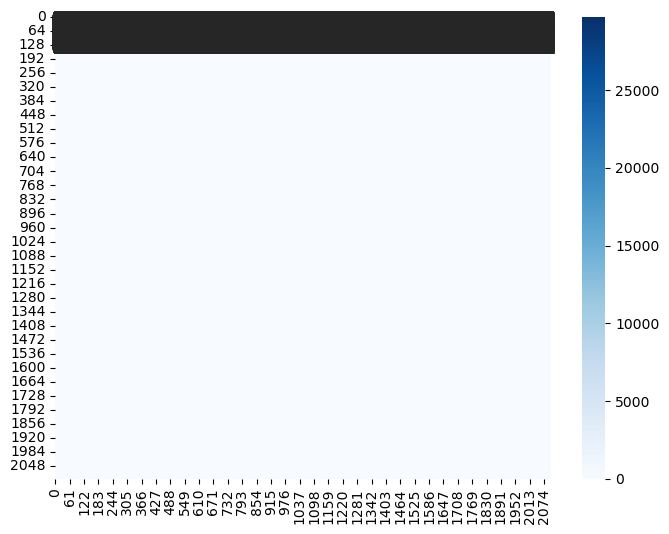

In [20]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Recall: {:.2f}".format(recall))
print("Precision: {:.2f}".format(precision))

cm = confusion_matrix(y_test,y_pred)
model.feature_names_ = ['3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

classifiers = []
predictions = []
fprs = []
tprs = []
aucs = []

for class_label in range(31):
    binary_y_train = (y_train == class_label).astype(int)
    binary_y_test = (y_test == class_label).astype(int)
    classifier = LogisticRegression()
    classifier.fit(X_train, binary_y_train)
    classifiers.append(classifier)

    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    predictions.append(y_pred_proba)


    fpr, tpr, _ = roc_curve(binary_y_test, y_pred_proba)
    fprs.append(fpr)
    tprs.append(tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

for class_label, roc_auc in enumerate(aucs):
    print(f"Class {class_label} - AUC: {roc_auc}")